# Taller Deep Learning Obligatorio



## Participantes

* Martin Martinez: 344567

* Rodrigo Paz: 325277




In [13]:
!pip install albumentations[imgaug] opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 41.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 10.2 MB/s eta 0:00:00


In [1]:
# Importamos todas las dependencias
import sys

sys.path.append('/kaggle/input/deep-learning-obligatorio')

from matplotlib import pyplot as plt

import os

from pathlib import Path

from SegmentationDataset import SegmentacionDataset

import torch

import torch.nn as nn

import torch.nn.functional as F

import torch.optim as optim

from torchinfo import summary

from torch.utils.data import DataLoader, random_split

from torchvision.transforms import v2 as T

from typing import Callable, Optional

import numpy as np

from UNet import UNet

from utils import (

    train,

    plot_taining,

    calculate_mean_and_std,

    rle_encode

)


/opt/anaconda3/envs/pytorch_m1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Fijamos la semilla para que los resultados sean reproducibles

SEED = 34

torch.manual_seed(SEED)

torch.backends.cudnn.deterministic = True

In [3]:
#Declaramos todas las variables globales y los hiper parametros del modelo

DEVICE = "cpu"

if torch.cuda.is_available():

    DEVICE = "cuda"

elif torch.backends.mps.is_available():

    DEVICE = "mps"



NUM_WORKERS = 0 if DEVICE == "mps" else max(os.cpu_count() - 1, 1)  #número de workers para cargar los datos a menos que estemos corriendo en Mac OS

BATCH_SIZE = 8  # tamaño del batch


print(f"Device: {DEVICE}")

print(f"Num Workers: {NUM_WORKERS}")

Device: mps
Num Workers: 0


### Dataset

Los datos provistos en la competencia de Kaggel, para cada muestra se tiene la imagen en formato PNG, en un tamaño fijo 800x800 y por separado tenemos en otra carpeta el resultado esperado de esta muestra. Crearemos un Dataset propio para cargar los X, Y

In [ ]:
DATA_DIR = 'tdl-segmentacion'
# TRAIN_DATA_DIR = Path(f'/kaggle/input/dataset/{DATA_DIR}/train')
TRAIN_DATA_DIR = Path('small-segmentation/train')
# TRAIN_DATA_DIR = Path('tdl-segmentacion/train')

IMAGE_SIZE = (400, 400) #Dimensiones de la imagen tiene que ser multiplos de 16 debido a la arquitectura de nuestra Unet



def create_train_val_datasets(

    validation_percentage: float = 0.2,

    x_transform: Optional[Callable] = None,

    y_transform: Optional[Callable] = None,

):

    full_train_dataset = SegmentacionDataset(

        root_dir = TRAIN_DATA_DIR,

        load_mask = True,

        x_transform = x_transform,

        y_transform = y_transform 

    )

    return full_train_dataset, random_split(

        full_train_dataset,

        [1 - validation_percentage, validation_percentage],

        generator = torch.Generator().manual_seed(SEED)

    )



ZERO_ONE_SCALE = True



#Creamos los DataSet

x_transform = [

    T.Resize(IMAGE_SIZE),

    T.ToImage(),

    T.ToDtype(torch.float32, scale = ZERO_ONE_SCALE),

]



y_transform = [

    T.Resize(IMAGE_SIZE),

    T.ToImage(),

    T.ToDtype(torch.float32)

]





_, (test_dataset, _) = create_train_val_datasets(

    x_transform =  T.Compose(x_transform),

    y_transform = T.Compose(y_transform)

)



test_loader = DataLoader(

        test_dataset,

        batch_size=BATCH_SIZE,

        shuffle=True,

        num_workers=NUM_WORKERS,

    )





images, masks = next(iter(test_loader))

image = images[0]

mask = masks[0]



print(f'{type(image)=},{type(mask)=}')

print(f'{image.shape=},{mask.shape=}')

type(image)=<class 'torch.Tensor'>,type(mask)=<class 'torch.Tensor'>
image.shape=torch.Size([3, 400, 400]),mask.shape=torch.Size([1, 800, 800])


In [5]:
#Analizamos la imagen y la mascara con sus valores

print(f'image cantidad de unos:{(image == 1 ).sum().item()}')

print(f'image cantidad de ceros:{(image == 0).sum().item()}')

print(f'image Cantidad de valores que no son cero ni uno:{((image > 0) & (image < 1)).sum().item()}')

print(f'image Cantidad de valores menores que cero:{(image < 0).sum().item()}')

print(f'image Cantidad de valores mayores que 1:{(image > 1).sum().item()}')

print(f'image Valores unicos :{ image.unique()}')



print(f'mask cantidad de unos:{(mask == 1 ).sum().item()}')

print(f'mask cantidad de ceros:{(mask == 0).sum().item()}')

print(f'mask Cantidad de valores que no son cero ni uno:{((mask > 0) & (mask < 1)).sum().item()}')

print(f'mask Cantidad de valores menores que cero:{(mask < 0).sum().item()}')

print(f'mask Cantidad de valores mayores que 1:{(mask > 1).sum().item()}')

print(f'mask Valores unicos :{ mask.unique()}')

image cantidad de unos:6598
image cantidad de ceros:1
image Cantidad de valores que no son cero ni uno:473401
image Cantidad de valores menores que cero:0
image Cantidad de valores mayores que 1:0
image Valores unicos :tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314,
        0.0353, 0.0392, 0.0431, 0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667,
        0.0706, 0.0745, 0.0784, 0.0824, 0.0863, 0.0902, 0.0941, 0.0980, 0.1020,
        0.1059, 0.1098, 0.1137, 0.1176, 0.1216, 0.1255, 0.1294, 0.1333, 0.1373,
        0.1412, 0.1451, 0.1490, 0.1529, 0.1569, 0.1608, 0.1647, 0.1686, 0.1725,
        0.1765, 0.1804, 0.1843, 0.1882, 0.1922, 0.1961, 0.2000, 0.2039, 0.2078,
        0.2118, 0.2157, 0.2196, 0.2235, 0.2275, 0.2314, 0.2353, 0.2392, 0.2431,
        0.2471, 0.2510, 0.2549, 0.2588, 0.2627, 0.2667, 0.2706, 0.2745, 0.2784,
        0.2824, 0.2863, 0.2902, 0.2941, 0.2980, 0.3020, 0.3059, 0.3098, 0.3137,
        0.3176, 0.3216, 0.3255, 0.3294, 0.3333, 0.3373, 0.341

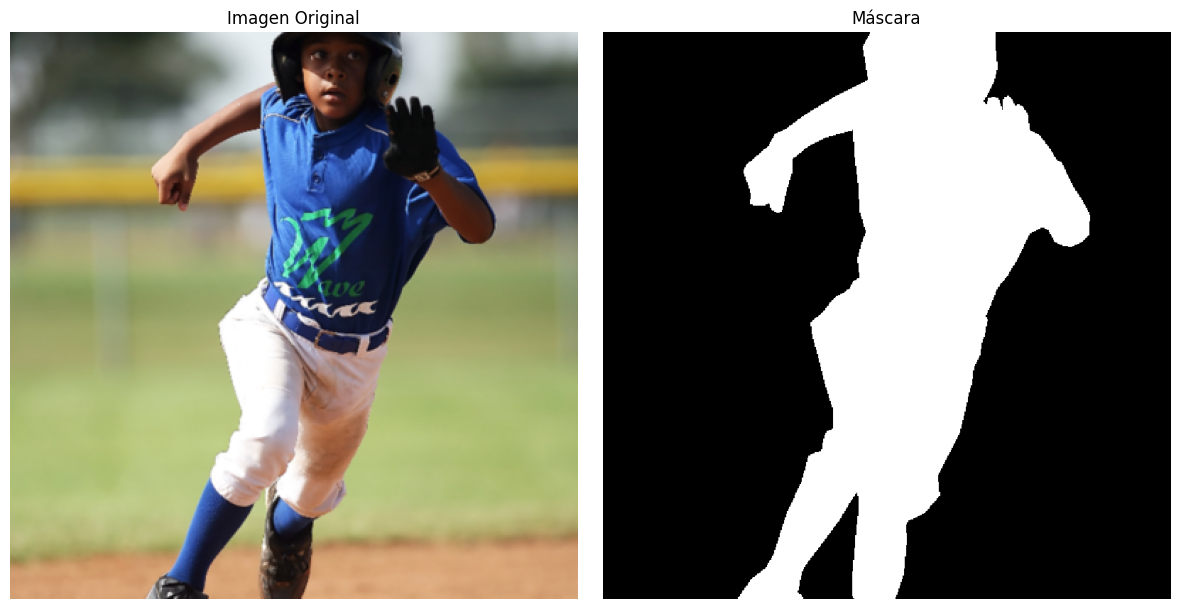

In [6]:
# Creamos una funcion que nos muestre la imagen original y su mascara

def plot_image_with_mask(

    image,

    mask

):

    """

    Muestra la imagen original y a su lado su respectiva mascara. Se asume que tanto la imagen y la mascara tienen el mismo tamaño

    """

    image_np = image.permute(1, 2, 0).numpy()

    mask_np = mask.squeeze(0).numpy()

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Mostrar la imagen original

    axs[0].imshow(image_np, vmin=0, vmax=1)

    axs[0].set_title("Imagen Original")

    axs[0].axis('off')

    axs[1].imshow(mask_np, cmap='gray', vmin=0, vmax=1)

    axs[1].set_title("Máscara")

    axs[1].axis('off')

    plt.tight_layout()

    plt.show()



plot_image_with_mask(image, mask)

In [7]:
#Calculamos media y desviacion estandar de las imagenes

mean_std_cache = f'{DATA_DIR}-mean-std-cache-scale-{ZERO_ONE_SCALE}.txt'

mean, std = calculate_mean_and_std(test_dataset, mean_std_cache)

print(f'Mean: {mean}')

print(f'Std: {std}')

Valor de la media y desviación estándar leídos del archivo
Mean: (0.5261733531951904, 0.4962290823459625, 0.4689851701259613)
Std: (0.23712751269340515, 0.23028001189231873, 0.23141558468341827)


### Generamos el modelo de U-Net

In [8]:
from DiceLoss import DiceLoss


model = UNet(input_channel=3, out_channel=1).to(DEVICE)
LR = 0.00005

CRITERION = nn.BCELoss().to(DEVICE)

# CRITERION = DiceLoss().to(DEVICE)

def log(epoch, train_loss, val_loss):

    print({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})



#Agregamos la normalizacion a las transformaciones
x_transform.append(T.Normalize(mean, std))

full_train_dataset, (train_dataset, val_dataset) = create_train_val_datasets(
    x_transform =  T.Compose(x_transform),
    y_transform = T.Compose(y_transform)
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

train_errors_ln_da, val_errors_ln_da, epochs_train = train(
    model = model,
    optimizer = optim.Adam(model.parameters(), lr=LR),
    criterion = CRITERION,
    train_loader = train_loader,
    val_loader = val_loader,
    device = DEVICE,
    patience = 5,
    epochs = 200,
    log_fn = log,
    log_every=1
)
print(f'Best epoch: {epochs_train}')

{'epoch': 0, 'train_loss': 0.7121318280696869, 'val_loss': 0.7057654857635498}
{'epoch': 1, 'train_loss': 0.6745334565639496, 'val_loss': 0.7075058817863464}
{'epoch': 2, 'train_loss': 0.6518354713916779, 'val_loss': 0.708990216255188}
{'epoch': 3, 'train_loss': 0.6384998559951782, 'val_loss': 0.7100017666816711}
{'epoch': 4, 'train_loss': 0.6131848990917206, 'val_loss': 0.7107374668121338}
{'epoch': 5, 'train_loss': 0.5838302075862885, 'val_loss': 0.7108199000358582}
Detener entrenamiento en la época 5, la mejor pérdida fue 0.70577 en la época 1
Best epoch: 1


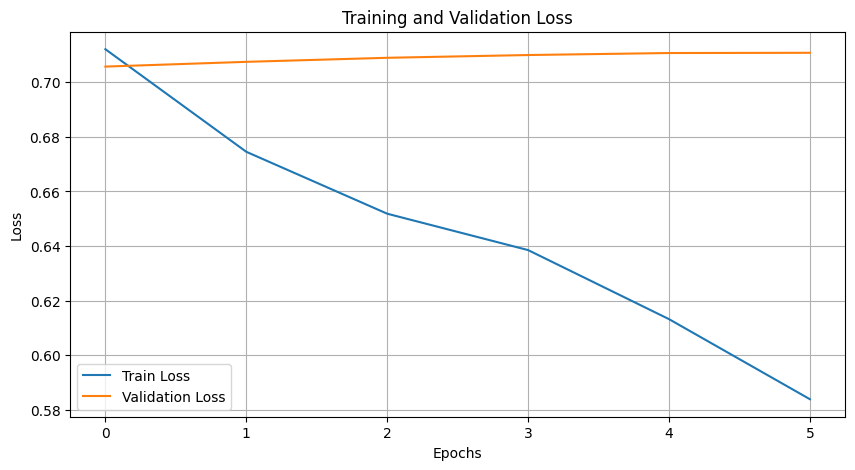

ValueError: Found input variables with inconsistent numbers of samples: [1920000, 480000]

In [ ]:
from utils import segmentation_classification_report

plot_taining(train_errors_ln_da, val_errors_ln_da)
# (accuracy, f1_score, precision, recall) = segmentation_classification_report(model, val_loader, DEVICE)
# print(f'Classification Report:')
# print(f'{accuracy = }')
# print(f'{f1_score = }')
# print(f'{precision = }')
# print(f'{recall = }')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.218947..2.2607458].


image.shape=torch.Size([3, 400, 400]),real_mask.shape=torch.Size([1, 800, 800])
cantidad de unos en real_mask:258558


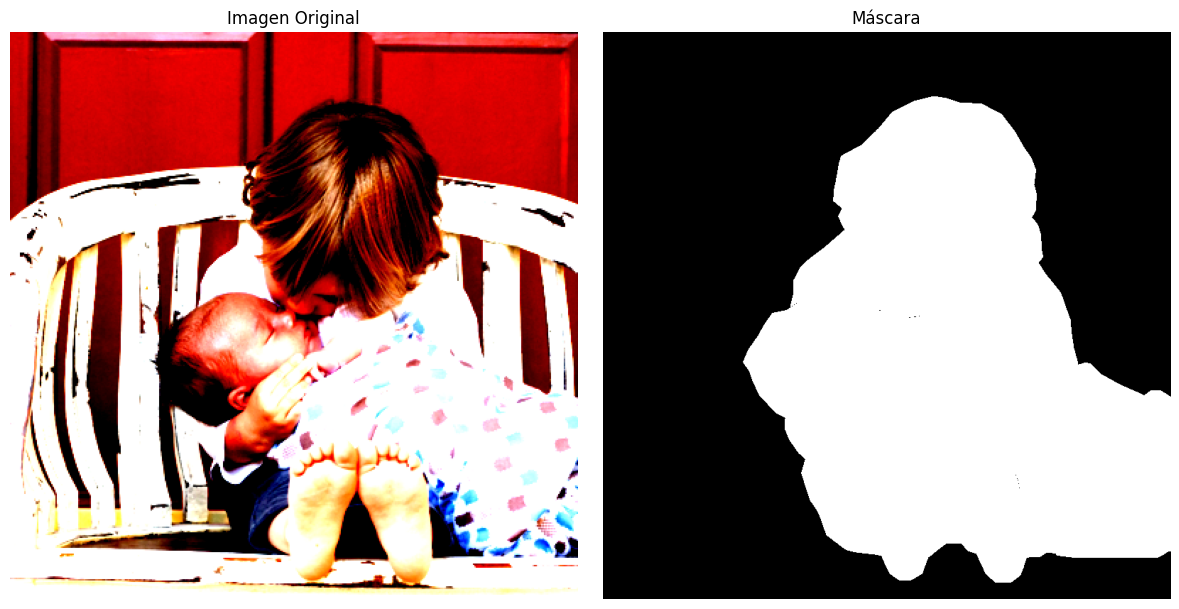

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
image.shape=torch.Size([3, 400, 400]),predicted_mask.shape=torch.Size([1, 400, 400])
cantidad de unos:0
cantidad de ceros:160000


In [11]:
#Comprobamos el modelo a ver como entrenó con una imagen y vemos su salida

images, masks = next(iter(train_loader))
image = images[0]
real_mask = masks[0]
print(f'{image.shape=},{real_mask.shape=}')
print(f'cantidad de unos en real_mask:{(real_mask > 0).sum().item()}')
plot_image_with_mask(image, real_mask)
model.eval()

with torch.no_grad():
    predicted_mask = model(image.unsqueeze(0).to(DEVICE))
    predicted_mask = predicted_mask.squeeze(0).cpu()
    predicted_mask = (predicted_mask > 0.5).float() #Binarizamos la mascara
    print(predicted_mask)

print(f'{image.shape=},{predicted_mask.shape=}')
print(f'cantidad de unos:{(predicted_mask == 1 ).sum().item()}')
print(f'cantidad de ceros:{(predicted_mask == 0 ).sum().item()}')
# delta = CRITERION(real_mask, predicted_mask).item()
# print(f'{delta=}')
# plot_image_with_mask(image, predicted_mask)


### Entrenamos de nuevo con la misma cantidad de épocas y usando todo el dataset (train + validation)

In [12]:
from utils import final_train

model = UNet(input_channel=3, out_channel=1).to(DEVICE)

def fina_train_log(epoch, train_loss):
    print({"epoch": epoch, "train_loss": train_loss})

full_train_dataloader = DataLoader(
    full_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

final_train(
    model = model,
    optimizer = optim.Adam(model.parameters(), lr=LR),
    criterion = CRITERION,
    train_loader = full_train_dataloader,
    device = DEVICE,
    epochs = epochs_train,
    log_fn = fina_train_log,
    log_every=1
)

{'epoch': 0, 'train_loss': 0.7293997605641683}
Epoch [1/1], Loss: 0.7294


In [ ]:
# Guardamos todos los pesos del modelo en un archivo
torch.save(model.state_dict(), 'unet_weights.pth')

In [ ]:
# Corremos el modelo en el conjunto de test
# TEST_DATA_DIR = Path(f'/kaggle/input/dataset/{DATA_DIR}/test')
# TEST_DATA_DIR = Path(f'small-segmentation/test')
TEST_DATA_DIR = Path(f'tdl-segmentacion/test')

test_dataset = SegmentacionDataset(
        root_dir = TEST_DATA_DIR,
        load_mask = False,
        x_transform = T.Compose(x_transform)
    )

test_dataloader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=NUM_WORKERS
    )

model.eval()
model.to(DEVICE)
with torch.no_grad():
    results = []
    for i, images in enumerate(test_dataloader):
        images = images.to(DEVICE)
        predicted_masks = model(images)
        # predicted_masks: [BATCH_SIZE, 1, *IMAGE_SIZE]
        predicted_masks = F.interpolate(predicted_masks, size=(800, 800), mode='bilinear', align_corners=False) #Tenemos que convertir la salida a 800x800
        predicted_masks = predicted_masks.squeeze(1).cpu()
        # predicted_masks: [BATCH_SIZE, 800, 800]
        predicted_masks = (predicted_masks > 0.5).float()
        id = f"{test_dataset.get_name(i)}"
        encoded_masks = rle_encode(predicted_masks)
        results.append((id, encoded_masks))
    print(len(results))

534


In [ ]:
#Guardamos las predicciones en un archivo para subir a Kaggle
import pandas as pd
submission_df = pd.DataFrame(results, columns=['id', 'encoded_pixels'])
submission_df['id'] = submission_df['id'].astype(str)
submission_df.to_csv("submission.csv", index=False)
print(submission_df.dtypes)


id                object
encoded_pixels    object
dtype: object
